In [65]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn import metrics

In [44]:
df_app_train_full = pd.read_csv('~/Desktop/kaggle/application_train.csv').sample(frac=1.0).reset_index(drop=True)

In [45]:
df_app_train = df_app_train_full[:4000]
val_mask = np.random.rand(len(df_app_train)) < 0.5
df_app_val = df_app_train[val_mask]
df_app_train = df_app_train[~val_mask]

In [46]:
df_app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,146237,0,Cash loans,F,Y,Y,1,90000.0,339241.5,12919.5,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0
1,131423,0,Revolving loans,F,N,Y,0,135000.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,325132,1,Revolving loans,F,N,Y,0,135000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
6,413838,0,Cash loans,F,N,N,2,171000.0,883863.0,23314.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
10,418936,0,Cash loans,F,N,Y,1,202500.0,486000.0,33952.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0


In [47]:
df_app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,1995.000000,1995.000000,1995.000000,1.995000e+03,1.995000e+03,1995.000000,1.994000e+03,1995.000000,1995.000000,1995.000000,...,1995.000000,1995.000000,1995.000000,1995.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000
mean,278554.361905,0.089223,0.424060,1.715868e+05,5.994987e+05,27127.978195,5.387163e+05,0.021238,-15998.789474,62305.940351,...,0.006015,0.002005,0.001003,0.000501,0.008032,0.008606,0.030981,0.306942,0.263339,2.008606
std,103305.210551,0.285137,0.726779,1.053738e+05,4.035781e+05,14017.284978,3.697431e+05,0.014265,4328.342596,140026.243076,...,0.077342,0.044744,0.031654,0.022389,0.095500,0.137367,0.200926,1.027963,0.603343,1.916583
min,100015.000000,0.000000,0.000000,2.700000e+04,5.094000e+04,3145.500000,4.500000e+04,0.001276,-25085.000000,-14974.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189239.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16429.500000,2.295000e+05,0.010006,-19583.000000,-2766.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,281718.000000,0.000000,0.000000,1.575000e+05,5.212800e+05,25537.500000,4.500000e+05,0.018850,-15694.000000,-1283.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367586.500000,0.000000,1.000000,2.025000e+05,8.131950e+05,34848.000000,6.885000e+05,0.028663,-12450.000000,-346.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,455761.000000,1.000000,5.000000,2.250000e+06,4.027680e+06,106380.000000,3.600000e+06,0.072508,-7722.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,4.000000,13.000000,5.000000,9.000000


In [53]:
categorical_columns = {col for col in df_app_train.columns
                           if df_app_train[col].dtype == np.object}
numeric_columns = {col for col in df_app_train.columns
                       if df_app_train[col].dtype == np.float64}

In [58]:
def preprocess(df: pd.DataFrame):
    for col in numeric_columns:
        s = df[col]
        df[col] = (s - s.mean()) / s.std()
        df[col].fillna(s.median(), inplace=True)

    cat_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']
    for col in cat_columns:
        df[col].fillna('MISSING', inplace=True)
        dum = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dum], axis=1)


In [59]:
preprocess(df_app_train)
preprocess(df_app_val)

df_app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,146237,0,Cash loans,F,Y,Y,1,-0.774261,-0.644874,-1.013640,...,0,0,0,0,-0.084106,-0.062649,-0.154191,-0.298592,2.878398,-0.526252
1,131423,0,Revolving loans,F,N,Y,0,-0.347210,-0.816443,-0.972227,...,0,0,0,0,-0.084106,-0.062649,-0.154191,-0.298592,-0.436467,-1.048014
5,325132,1,Revolving loans,F,N,Y,0,-0.347210,-1.039449,-1.293259,...,0,0,0,0,-0.084106,-0.062649,-0.154191,-0.298592,-0.436467,-1.048014
6,413838,0,Cash loans,F,N,N,2,-0.005569,0.704608,-0.272055,...,0,0,0,0,-0.084106,-0.062649,-0.154191,-0.298592,-0.436467,-0.526252
10,418936,0,Cash loans,F,N,Y,1,0.293367,-0.281231,0.486865,...,0,0,0,0,-0.084106,-0.062649,-0.154191,0.674205,-0.436467,-0.526252


In [95]:
top20_features = [
    'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION',
    'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_1', 'AMT_ANNUITY',
    'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE',
    'HOUR_APPR_PROCESS_START', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
    'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_FAM_MEMBERS', 'OWN_CAR_AGE',
    'AMT_REQ_CREDIT_BUREAU_QRT', 'REGION_RATING_CLIENT',
    'OBS_60_CNT_SOCIAL_CIRCLE',
]

In [96]:
def select_features(df):
    return df[top20_features].copy()

X = select_features(df_app_train)
y = df_app_train.TARGET

X.head()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_1,AMT_ANNUITY,DAYS_EMPLOYED,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,HOUR_APPR_PROCESS_START,AMT_CREDIT,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_YEAR,CNT_FAM_MEMBERS,OWN_CAR_AGE,AMT_REQ_CREDIT_BUREAU_QRT,REGION_RATING_CLIENT,OBS_60_CNT_SOCIAL_CIRCLE
0,-1.886183,-0.321942,-2602,0.652689,-10300,0.280331,0.027003,-1.013640,-2481,-0.774261,0.275228,14,-0.644874,-0.811959,-0.526252,0.915756,4.460916,2.878398,2,-0.558526
1,-1.676269,0.683969,-4122,-0.469944,-14341,0.813083,1.249134,-0.972227,-4254,-0.347210,-0.108570,14,-0.816443,-0.726765,-1.048014,-0.201634,-0.175507,-0.436467,2,0.626974
5,0.761470,0.843383,-289,-0.864704,-16753,-1.039443,0.027003,-1.293259,-2316,-0.347210,0.520508,10,-1.039449,-0.970177,-1.048014,-0.201634,-0.175507,-0.436467,2,-0.163359
6,0.054717,-0.941761,-2076,1.295728,-9998,0.916002,0.027003,-0.272055,-2452,-0.005569,-0.834457,16,0.704608,0.538395,-0.526252,2.033147,-0.175507,-0.436467,2,-0.163359
10,-1.782180,-0.469135,-3725,0.358033,-12949,0.919634,0.813053,0.486865,-1085,0.293367,-0.212319,8,-0.281231,-0.142576,-0.526252,-0.201634,-0.175507,-0.436467,3,0.231807


In [97]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, oob_score=True)
model.fit(X, y)
metrics.roc_auc_score(y, model.oob_prediction_)

0.55949583521423751

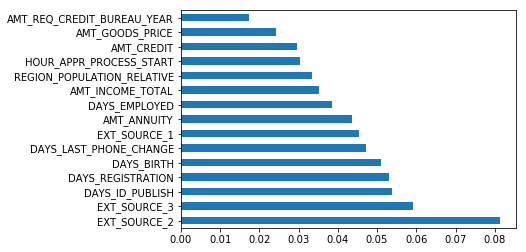

In [91]:
features = pd.Series(model.feature_importances_, index=X.columns)
features = features.sort_values(ascending=False)
features[:15].plot('barh')

In [94]:
pd.DataFrame(features[:20]).index

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION',
       'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_1', 'AMT_ANNUITY',
       'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE',
       'HOUR_APPR_PROCESS_START', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_FAM_MEMBERS', 'OWN_CAR_AGE',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'REGION_RATING_CLIENT',
       'OBS_60_CNT_SOCIAL_CIRCLE'],
      dtype='object')